In [1]:
import pandas as pd
import umap
import glob
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.cm as cm

from sklearn.neighbors import NearestNeighbors

from matplotlib import cm

from scipy.ndimage import uniform_filter1d
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

from umap import UMAP

import statsmodels.api as sm

from sklearn.decomposition import PCA



/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_left"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
lab = "Sex"
lab2 = "Age"
model_path = glob.glob(f"{path}/*")[0]
ukb_emb_file = f"{model_path}/ukb40_random_embeddings/full_embeddings.csv"
print(ukb_emb_file)

/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_left/11-53-20_94_0/ukb40_random_embeddings/full_embeddings.csv


In [3]:
ukb_emb = pd.read_csv(ukb_emb_file, index_col=0)
ukb_emb.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,9.855339,45.631443,10.060020,51.771660,8.478070,4.988151,-8.140727,-10.911059,43.815570,-10.105584,...,33.118095,-15.624771,-27.941100,2.852160,46.157475,24.440798,24.746952,132.67224,-39.249332,-10.191565
sub-1000325,36.622623,-10.259095,7.265591,30.991932,-14.519362,-15.731174,-31.460690,4.107340,-55.111850,38.218185,...,-52.196083,-7.545823,-16.506243,39.789757,38.814830,25.683529,27.407000,119.90040,-64.905846,-65.995575
sub-1000458,-34.563812,-28.634380,2.802658,20.492140,-11.130139,-8.628111,-3.044661,-22.876516,9.188710,37.231148,...,45.947090,0.169109,9.217993,65.817444,12.340383,-59.395767,6.378770,106.78734,7.183937,3.183411
sub-1000575,-7.034242,-41.465206,-8.991343,63.184370,-0.292778,-26.021795,-15.396147,-12.797480,0.084663,41.402267,...,-45.141834,8.213155,2.001921,40.315105,-7.051990,-47.676765,19.328588,123.70115,28.073114,-29.807207
sub-1000606,-66.415245,-18.612453,-2.978323,27.743166,11.945621,-56.238567,-2.480288,4.316528,12.236313,-1.701040,...,-36.500490,-10.481411,-12.624851,7.911556,-35.915565,-10.178987,26.869083,148.25537,79.333950,2.007291


In [4]:
participants = pd.read_csv(participants_file, index_col=0)
participants = participants[[lab, lab2]].dropna()
participants.head()

,Sex,Age
participant_id,,
sub-3411469,1,65.0
sub-2290292,0,69.0
sub-3842391,0,70.0
sub-2758537,1,49.0
sub-4334619,1,70.0


In [5]:
merged = participants[[lab, lab2]].merge(ukb_emb, left_index=True, right_index=True)
# UKB latent space analysis

In [6]:
embeddings = merged.iloc[:,2:]
label = merged.iloc[:,0:2]
label_random = label.copy()
label_random[:] = label_random.sample(frac=1).values
# print(embeddings.head())
print(label.head())
print(label_random.head())

             Sex   Age
sub-3411469    1  65.0
sub-2290292    0  69.0
sub-3842391    0  70.0
sub-2758537    1  49.0
sub-4334619    1  70.0
             Sex   Age
sub-3411469    1  52.0
sub-2290292    1  71.0
sub-3842391    1  74.0
sub-2758537    1  49.0
sub-4334619    1  54.0


In [7]:
# Construct nearest_neighbor matrix
nbrs = NearestNeighbors(n_neighbors=2000, algorithm='brute').fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)
indices.shape

(37715, 2000)

In [8]:
def construct_average_nearest_neighbors(label):
    # Takes list of incides whose label is 1
    label_red = label.reset_index().iloc[:,[1]]
    label_1 = label_red[label_red.iloc[:,0]==1].index.to_list()
    
    # In the indices matrix, put value of label corresponding to index
    neighbors = indices[:,1:]
    labels1 = np.in1d(neighbors, label_1)
    labels1 = labels1.reshape(neighbors.shape).astype(int)
    
    # Makes moving average along nearest neighbor
    labels1_cum = np.cumsum(labels1, axis=1)
    means_npy = np.zeros(labels1_cum.shape)
    for idx in range(len(labels1)):
        means_npy[idx,:] = labels1_cum[idx,:]/(np.arange(1, labels1_cum.shape[1]+1, 1).reshape(1,-1))
        
    return labels1, means_npy

In [9]:
def construct_average_nearest_neighbors_continuous(label):
    label_red = label.reset_index().iloc[:,[1]].values

    # In the indices matrix, put value of label corresponding to index
    neighbors = indices[:,1:]
    labels1 = np.zeros(neighbors.shape)
    for idx in range(len(neighbors)):
        for j in range(neighbors.shape[1]):
            labels1[idx, j] = label_red[neighbors[idx, j]]
    
    # Makes moving average along nearest neighbor
    labels1_cum = np.cumsum(labels1, axis=1)
    
    means_npy = np.zeros(labels1_cum.shape)
    for idx in range(len(labels1)):
        means_npy[idx,:] = labels1_cum[idx,:]/(np.arange(1, labels1_cum.shape[1]+1, 1).reshape(1,-1))
        
    return labels1, means_npy

In [10]:
def construct_average_distance_nearest_neighbors():

    # Makes moving average along nearest neighbor
    distances_cum = np.cumsum(distances[:,1:], axis=1)
    means_distance = np.zeros(distances_cum.shape)
    for idx in range(len(distances)):
        means_distance[idx,:] = distances_cum[idx,:]/(np.arange(1, distances_cum.shape[1]+1, 1).reshape(1,-1))
        
    return means_distance

In [11]:
values_npy, means_npy = construct_average_nearest_neighbors(label.iloc[:,[0]])

In [12]:
values2_npy, means2_npy = construct_average_nearest_neighbors_continuous(label.iloc[:,[1]])

/tmp/ipykernel_74432/1841607536.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels1[idx, j] = label_red[neighbors[idx, j]]


In [13]:
val_random_npy, random_npy = construct_average_nearest_neighbors(label_random.iloc[:,[0]])

In [14]:
val2_random_npy, random2_npy = construct_average_nearest_neighbors_continuous(label_random.iloc[:,[1]])

/tmp/ipykernel_74432/1841607536.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels1[idx, j] = label_red[neighbors[idx, j]]


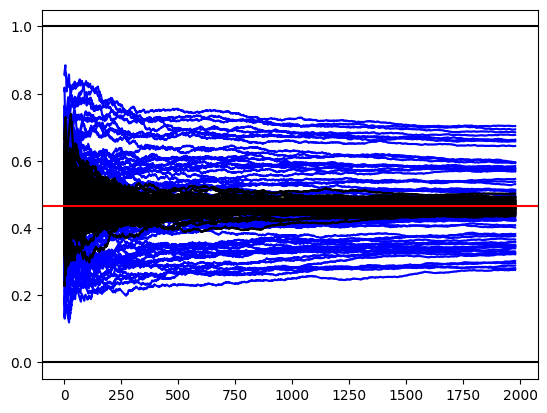

In [15]:
for idx in range(1,35000,500):
    plt.plot(means_npy[idx, 20:], color='b')
for idx in range(1,35000,500):
    plt.plot(random_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab].values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

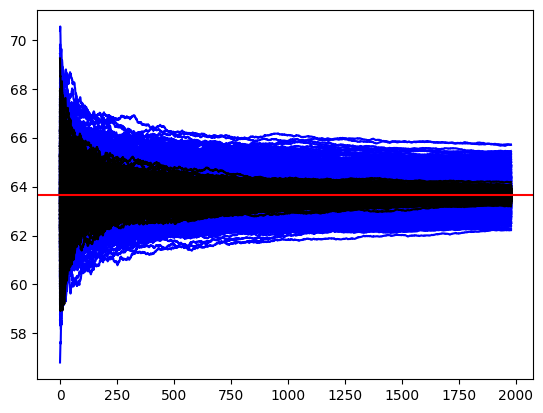

In [16]:
for idx in range(1,35000,50):
    plt.plot(means2_npy[idx, 20:], color='b')
for idx in range(1,35000,50):
    plt.plot(random2_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label[lab2].values), color='r', linestyle='-')
plt.show()

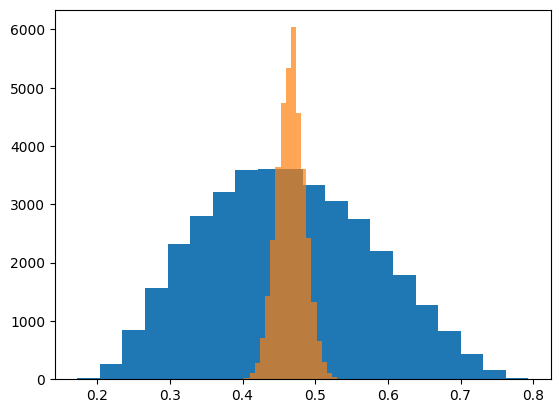

In [17]:
nb_neighbors=1000
plt.hist(means_npy[:, nb_neighbors], bins=20)
plt.hist(random_npy[:, nb_neighbors], bins=20, alpha=0.7)
plt.show()

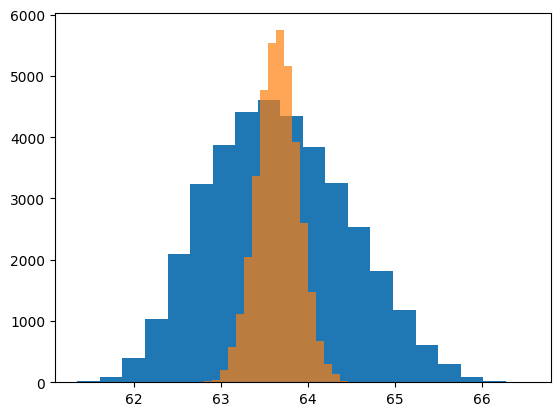

In [24]:
nb_neighbors=1000
plt.hist(means2_npy[:, nb_neighbors], bins=20)
plt.hist(random2_npy[:, nb_neighbors], bins=20, alpha=0.7)
plt.show()

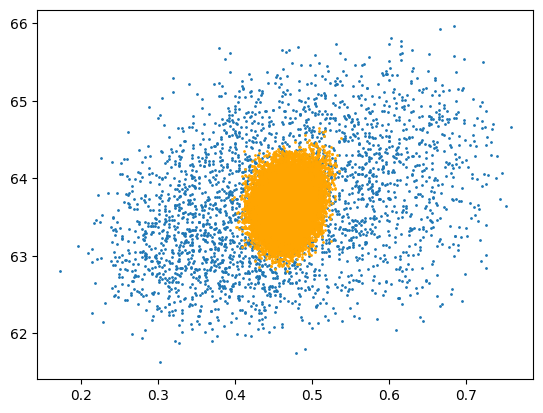

In [27]:
nb_neighbors=1000
plt.scatter(means_npy[:3000, nb_neighbors], means2_npy[:3000, nb_neighbors], s=1)
plt.scatter(random_npy[:, nb_neighbors], random2_npy[:, nb_neighbors], s=1, c='orange')